
# Support Vector Machine


## Initialization: courtesy of Tove

In [171]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib.pyplot import colorbar
from scipy.special import logit
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, SequentialFeatureSelector  # RFE only works for linear SVM
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, cohen_kappa_score

from collections import Counter, defaultdict
import pickle
#plt.style.use("seaborn-v0_8-colorblind")
# The following lets us import cleanup.py
# Specifically it adds SF295_G007 to the python system path

from cleanup import removeRows
from SVM.model import svm_model


In [172]:
data_processor = removeRows("../project_train.csv", rows_to_remove=[69, 85, 95])  # speechiness has an "outlier" as in one datapoint far away from the rest
data_processor.process_rows();
data = data_processor.df


Row 69 will be removed:
danceability          0.715
energy                0.288
key                   1.000
loudness            -13.843
mode                  1.000
speechiness           0.925
acousticness          0.785
instrumentalness      0.000
liveness              0.688
valence               0.772
tempo               115.114
Label                 0.000
Name: 68, dtype: float64

Row 85 will be removed:
danceability         0.4080
energy               0.7140
key                  0.0000
loudness            -6.9420
mode                 1.0000
speechiness          0.0666
acousticness         0.0356
instrumentalness     0.0000
liveness             0.2580
valence              0.7600
tempo               75.3970
Label                1.0000
Name: 85, dtype: float64

Row 95 will be removed:
danceability         0.8060
energy               0.6080
key                  1.0000
loudness            -7.0080
mode                 1.0000
speechiness          0.0659
acousticness         0.0113
instrum

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


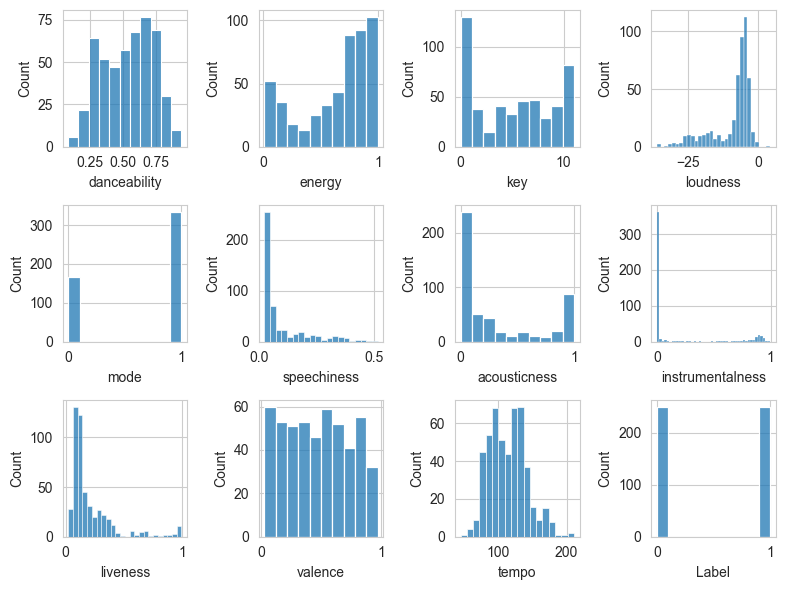

In [173]:
# Check distribution
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(data.columns):
    sns.histplot(data[col], kde=False, ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.savefig('Distribution.eps', format='eps')
plt.show()

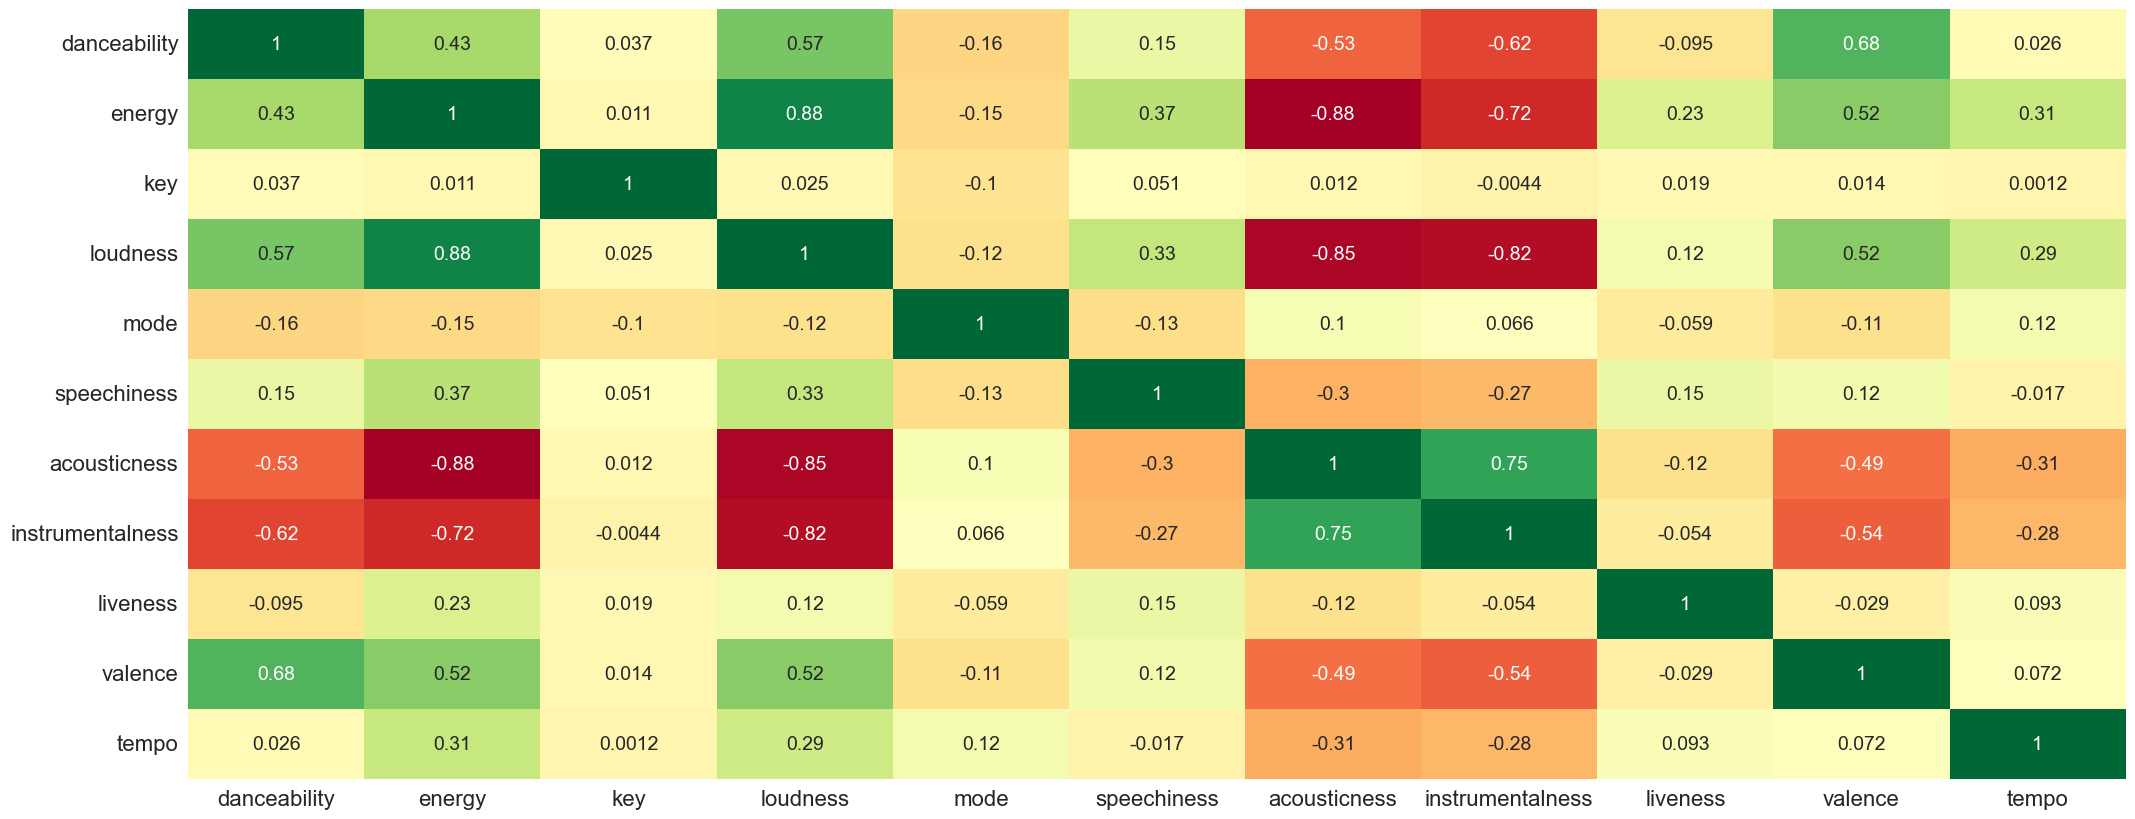

In [174]:
# heat map of correlation
features = data.drop([] + ["Label"], axis=1)
plt.figure(figsize=(25,10))
sns.heatmap(features.corr(), annot=True, cmap='RdYlGn', cbar=False, annot_kws={"size": 14})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Correlation.eps', format='eps')

In [63]:
# Create the pairplot with scatter plots for off-diagonal and probability distributions (KDE) on diagonal
#sns.pairplot(data, hue = "Label", diag_kws={'fill': False}, corner=True)

## Transforming data - courtesy of Tove

In [175]:
vars_to_transform = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "liveness",
    "valence",
]

transformed_data = data.copy()
transformed_data[vars_to_transform] = transformed_data[vars_to_transform].transform(logit)

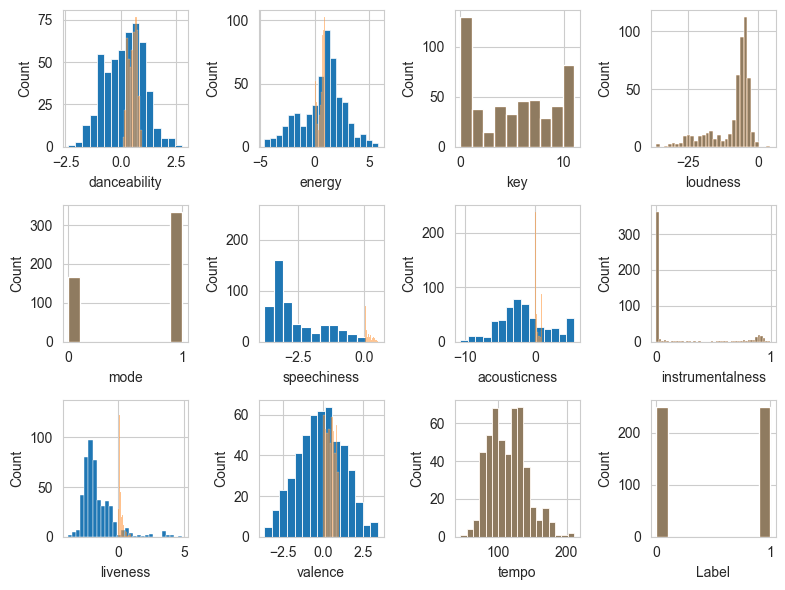

In [176]:
# Check distribution again, comparing transformed (blue) with initial (orange)
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(data.columns):
    sns.histplot(transformed_data[col], ax=axes[i],alpha=1)
    sns.histplot(data[col], ax=axes[i], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [66]:
#sns.pairplot(transformed_data[vars_to_transform + ["Label"]], hue = "Label", diag_kws={'fill': False})

In [177]:
scaled_data = transformed_data.copy()
scaled_data[vars_to_transform + ["loudness", "tempo"]] = preprocessing.scale(
    scaled_data[vars_to_transform + ["loudness", "tempo"]]
)
#sns.pairplot(scaled_data[vars_to_transform + ["loudness", "tempo", "Label"]], hue = "Label", diag_kws={'fill': False})

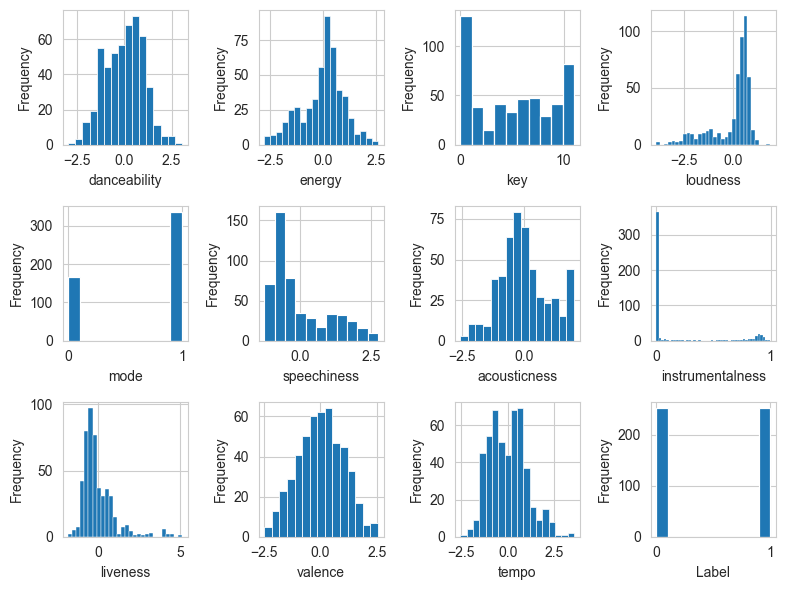

In [178]:
# Check distribution again, comparing scaled (blue) with transformed (orange)
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(scaled_data.columns):
    sns.histplot(scaled_data[col], ax=axes[i],alpha=1)
    #sns.histplot(transformed_data[col], ax=axes[i], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [179]:
all_predictors = scaled_data.drop([] + ["Label"], axis=1)
response = scaled_data["Label"]

# We drop_first because one of the variables in each of key,
# mode is determined by the values of the others
# (for example mode != 0 implies mode = 1)
encoded_data = pd.get_dummies(
    all_predictors, columns=["key", "mode"], drop_first=True
)

predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.3, random_state=8)

<Axes: >

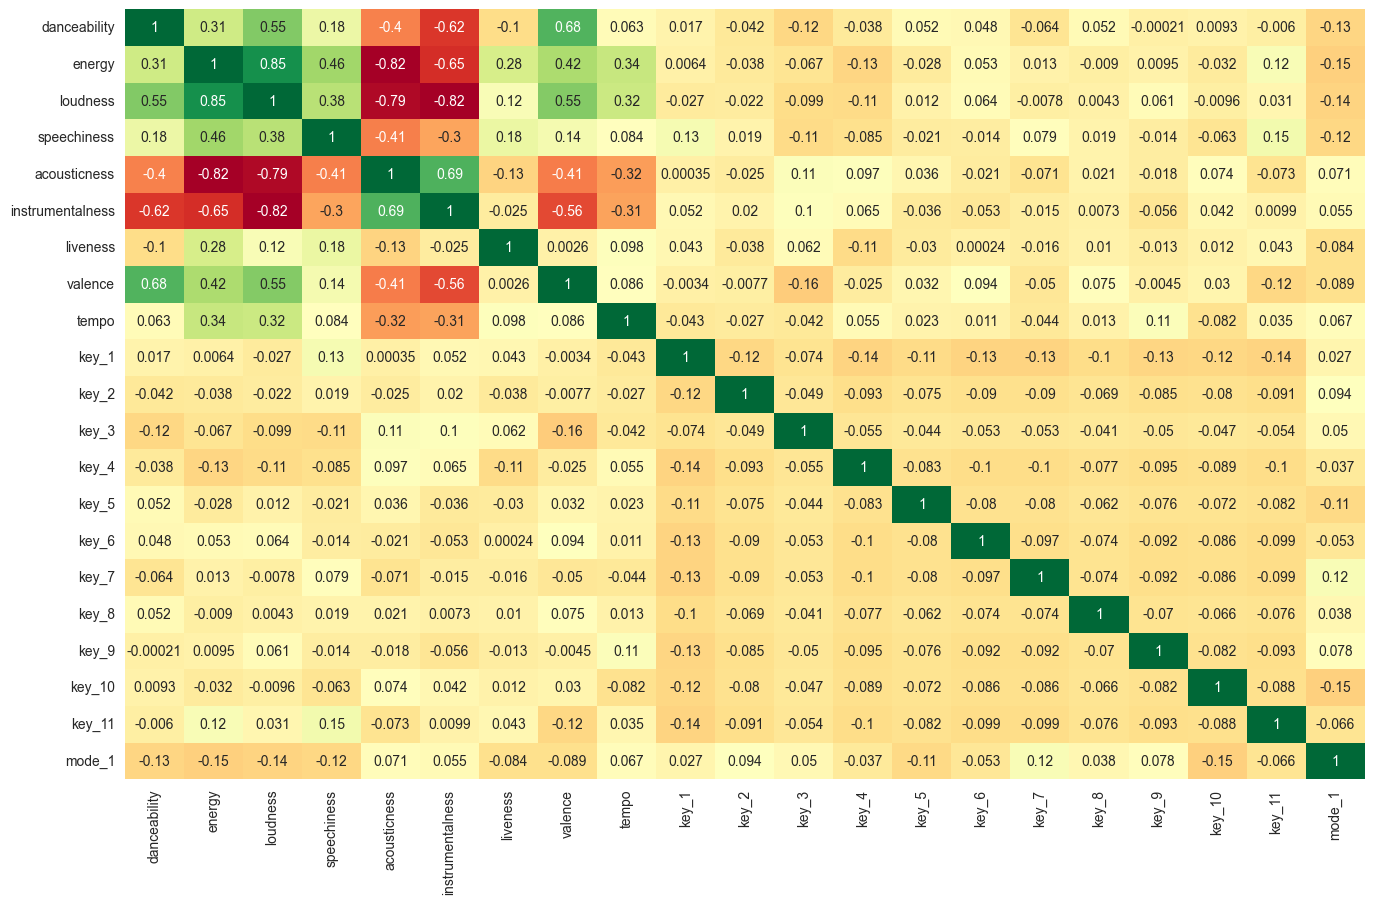

In [180]:
# heat map of correlation
plt.figure(figsize=(16,10))
sns.heatmap(predictors_train.corr(), annot=True, cmap='RdYlGn', cbar=False)

There are some redundancies.

# <span style="color:red">Intermediate conclusions</span>

1. The outcome of the model "accuracy" on the test split is *higly!!* dependent on the randomization seed when splitting the data into train/test sets.
2. The combination of logit transform and scaling has a good effect on recall and overall accuracy.
3. Checking for correlation among independent variables and proactively removing dependent features is not needed, backward feature selection works well.
4. Reducing the number of features only marginally reduce accuracy, thus it is highly desired to reduce the number of features to improve generalization and avoid overfitting. 
5. To improve the model, tuning hyperparameters can be attempted.

### Attempting to find a trend between selected features and accuracies across feature set sizes and randomization seed, while also comparing the performance of default hyperparameters with the performance when adjusting gamma and C. This is to avoid inflating the confidence in a model's accuracy based on the performance on a random small test set.

In [181]:
C_grid = [0.001, 0.01, 0.1, 1, 10, 100]
gamma_grid = [0.001, 0.01, 0.1, 1, 10, 100]

if os.path.exists('accuracy_orig_dict.pkl') and os.path.exists('accuracy_mod_dict.pkl') and os.path.exists('bestfeatures.pkl'):
    # Load dictionary from file
    with open('accuracy_orig_dict.pkl', 'rb') as f:
        accuracy_orig_dict = pickle.load(f)
    
    with open('accuracy_mod_dict.pkl', 'rb') as f:
        accuracy_mod_dict = pickle.load(f)
        
    with open('bestfeatures.pkl', 'rb') as f:
        bestfeatures = pickle.load(f)
    
else:
    # Basically I loop through the values of how many features we want to keep with backward feature selection. I choose 8 as minimum number of features.
    # Second loop is going through an arbitrary number of different seed values to see how much it affects the outcome.
    
    accuracy_orig_dict = {}
    accuracy_mod_dict = {}
    bestfeatures = {}
    for i in range(1, predictors_train.shape[1] + 1):
        bestfeatures[i] = {}
        accuracy_orig_dict[i] = {}
        accuracy_mod_dict[i] = {}
        for j in range(100):
            if i == predictors_train.shape[1]:
                seed = j
                print(f'{i} features, seed = {seed}..', end='')
                predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.3, random_state=seed)
                bestfeatures[i][seed] = predictors_test.columns
                model, accuracy = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, metrics='None')
                n_features = predictors_train.shape[1]
                X_variance = predictors_train.var().mean()
                gamma_value = 1 / (n_features * X_variance)
                
                accuracy_mod_dict[i][seed] = {}
                
                for k in range(len(C_grid)):
                    accuracy_mod_dict[i][seed][k] = {}
                    for l in range(len(gamma_grid)):
                        _, accuracy_mod = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, c = C_grid[k], gamma = gamma_grid[l], metrics='None')
                        accuracy_mod_dict[i][seed][k][l] = accuracy_mod
                
                accuracy_orig_dict[i][seed] = accuracy
                print('Training DONE.')
    
            else:
                seed = j
                print(f'{i} features, seed = {seed}..', end='')
                predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.3, random_state=seed)  # increasing test size
                
                sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i, direction='backward')
                sfs.fit(predictors_train, response_train)
                
                selected_features = sfs.get_support()  # Boolean mask of selected features    
                predictors_train_sfs = predictors_train.loc[:, selected_features]
                predictors_test_sfs = predictors_test.loc[:, selected_features]
                print('Predictors DONE.. ', end='')
                bestfeatures[i][seed] = predictors_test_sfs.columns
                
                model, accuracy = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, metrics='None')
                
                n_features = predictors_train_sfs.shape[1]
                X_variance = predictors_train_sfs.var().mean()
                gamma_value = 1 / (n_features * X_variance)
                
                accuracy_mod_dict[i][seed] = {}
                for k in range(len(C_grid)):
                    accuracy_mod_dict[i][seed][k] = {}
                    for l in range(len(gamma_grid)):
                        _, accuracy_mod = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, c = C_grid[k], gamma = round(gamma_grid[l],4), metrics='None')
                        accuracy_mod_dict[i][seed][k][l] = accuracy_mod
                
                accuracy_orig_dict[i][seed] = accuracy
                print('Training DONE.')
                
    # Saving the dictionaries into file for next time:
    with open('accuracy_orig_dict.pkl', 'wb') as f:
        pickle.dump(accuracy_orig_dict, f)
        
    with open('accuracy_mod_dict.pkl', 'wb') as f:
        pickle.dump(accuracy_mod_dict, f)
    
    with open('bestfeatures.pkl', 'wb') as f:
        pickle.dump(bestfeatures, f)

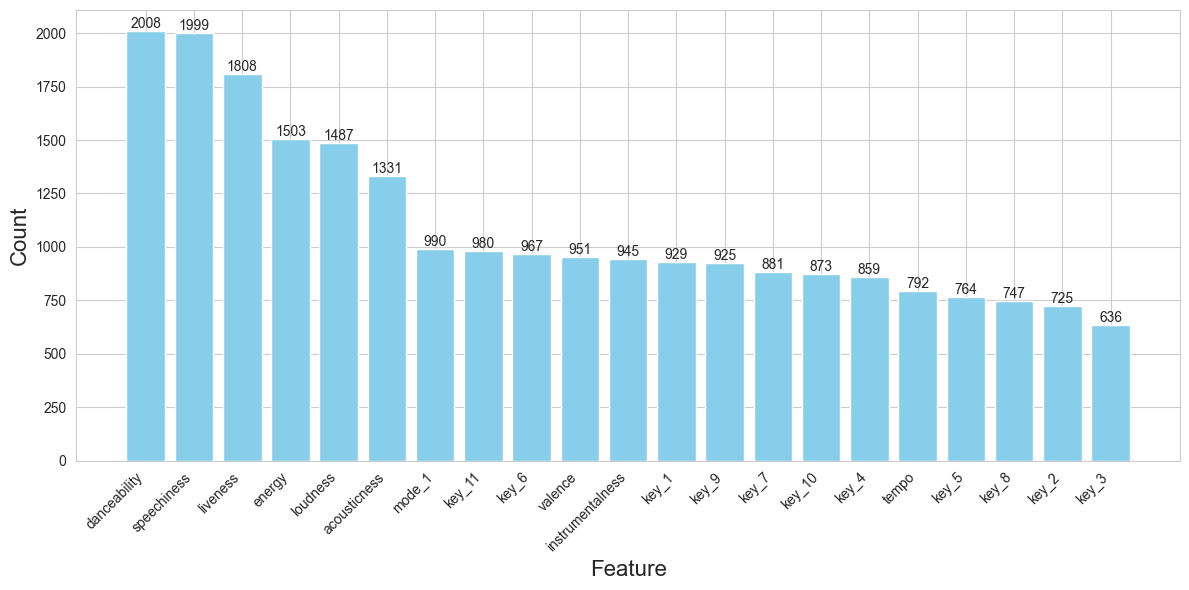

In [182]:
all_features = []
for feature in bestfeatures:
    for seed in bestfeatures[feature]:
        all_features.extend(bestfeatures[feature][seed])

feature_counts = Counter(all_features)

sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
features, counts = zip(*sorted_features)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(features, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Count', fontsize=16)
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.savefig('FeatureCount_all.eps', format='eps')
plt.show()

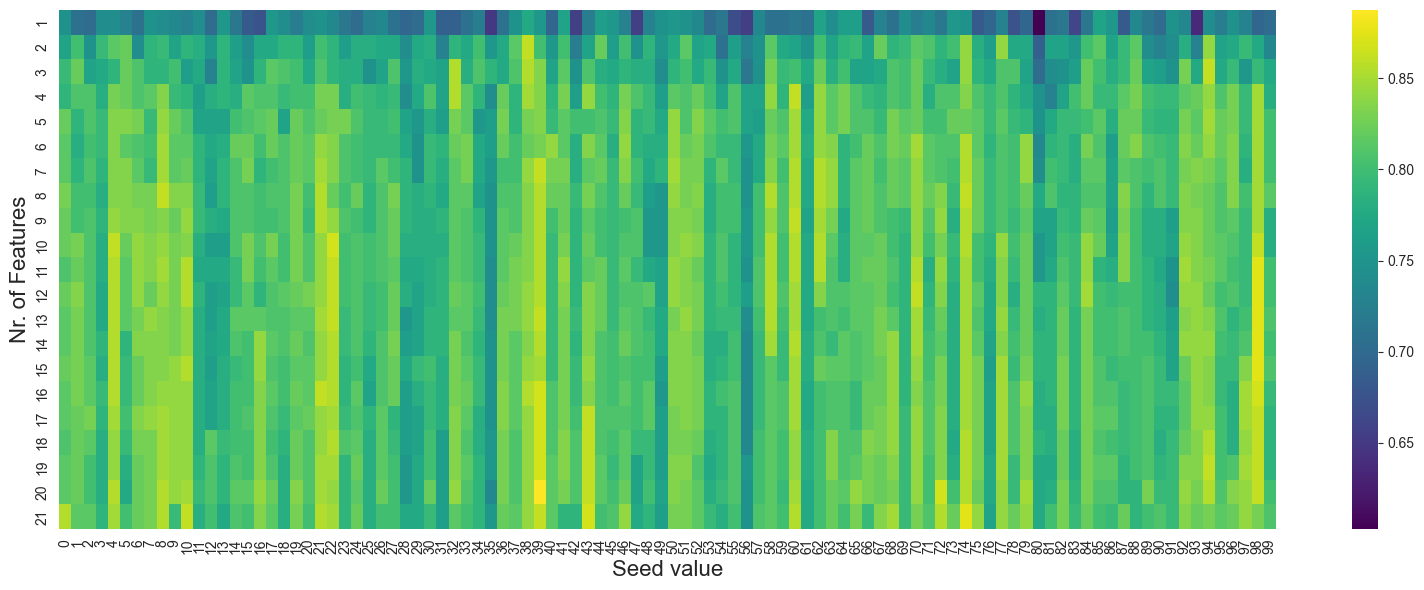

In [183]:
# default parameters
n_features = sorted(accuracy_orig_dict.keys())
seed_nrs = range(100)
Z = np.array([[accuracy_orig_dict[n_feature][seed_nr] for n_feature in n_features] for seed_nr in seed_nrs])

# Create a heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(Z.T, xticklabels=seed_nrs, yticklabels=n_features, cmap='viridis', annot=False)
plt.xlabel('Seed value', fontsize=16)
plt.ylabel('Nr. of Features', fontsize=16)
plt.tight_layout()
plt.savefig('AccuracyHeatmap_all.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


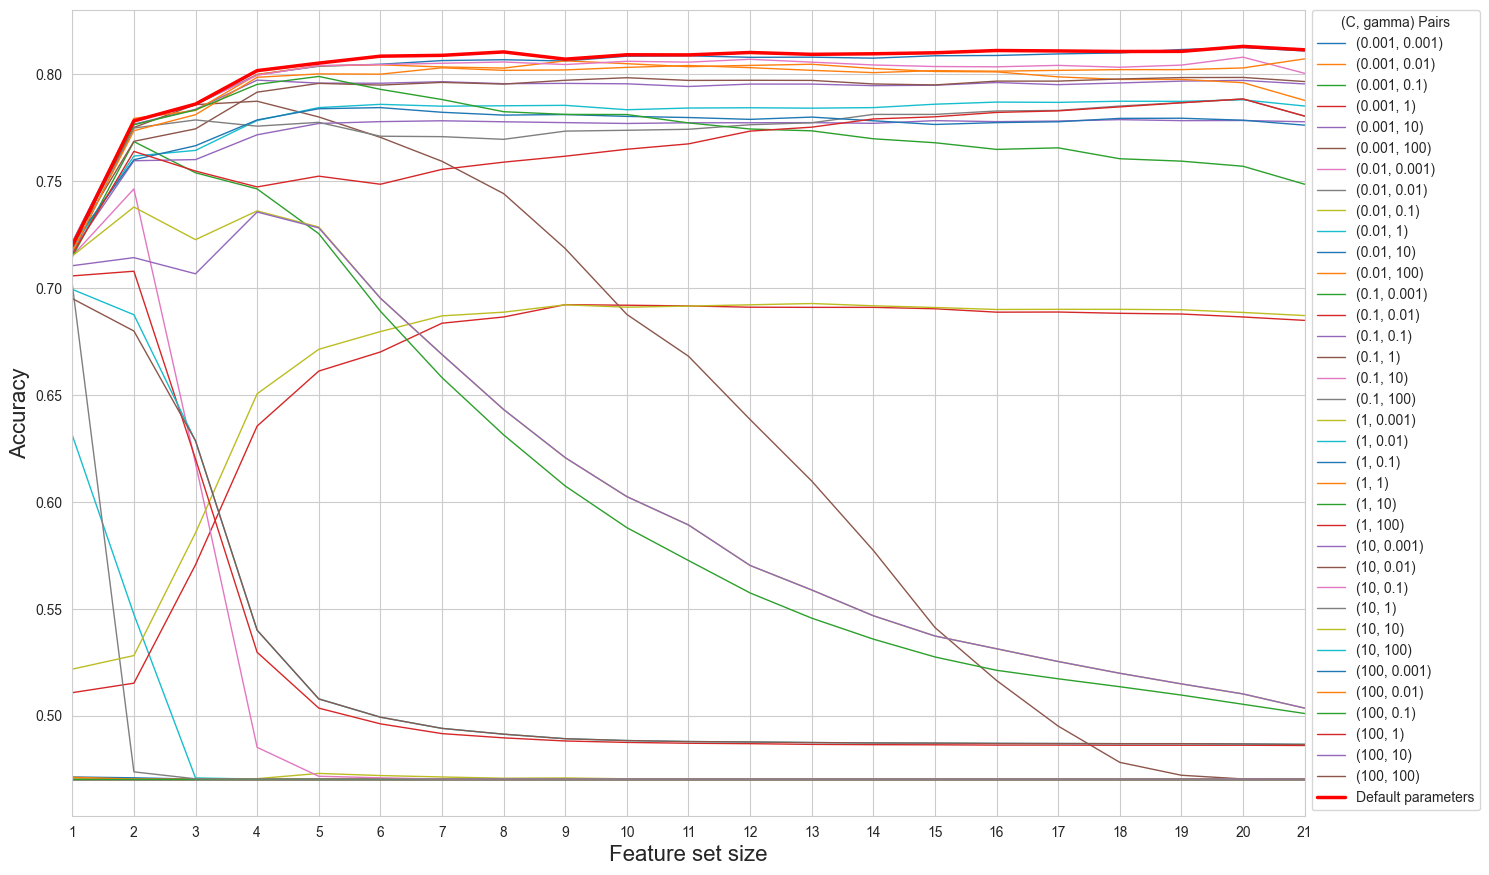

In [211]:
average_dict_orig = {key: sum(values.values()) / len(values) for key, values in accuracy_orig_dict.items()}
keys_orig = list(average_dict_orig.keys())    # Top-level keys (1 to 21)
values_orig = list(average_dict_orig.values())  # Corresponding average values

sum_dict_mod = {}

# Iterate through the dictionary to collect sums and counts
for i, val_i in accuracy_orig_dict.items():
    sum_dict_mod[i] = {}
    for seed, val_seed in accuracy_mod_dict[i].items():
        for k, val_k in accuracy_mod_dict[i][seed].items():
            if k not in sum_dict_mod[i]:
                sum_dict_mod[i][k] = {}
            for l, val_l in accuracy_mod_dict[i][seed][k].items():
                if l not in sum_dict_mod[i][k]:
                    sum_dict_mod[i][k][l] = 0
                value = accuracy_mod_dict[i][seed][k][l]
                sum_dict_mod[i][k][l] += value 

# Create the result dictionary for averages
average_dict_mod = {}
for i in sum_dict_mod:
    average_dict_mod[i] = {}
    for k in sum_dict_mod[i]:
        if k not in average_dict_mod[i]:
            average_dict_mod[i][k] = {}
        for l in sum_dict_mod[i][k]:
            average_dict_mod[i][k][l] = sum_dict_mod[i][k][l] / len(accuracy_mod_dict[i].items())

plt.figure(figsize=(15, 9.25))
for k in average_dict_mod[1]:  # Get k from the first i
        for l in average_dict_mod[1][k]:  # Get l from the first i
            # Prepare x and y data for plotting
            x = list(average_dict_mod.keys())
            #print(x)# i values (x-axis)
            y = [average_dict_mod[i][k][l] for i in x]  # corresponding y values
            #print(y)
            # Plotting
            plt.plot(x, y, label=f'({C_grid[k]}, {gamma_grid[l]})', linewidth=1)
plt.plot(keys_orig, values_orig, linewidth=2.5, color='red', label='Default parameters')
plt.xlabel('Feature set size', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(title='(C, gamma) Pairs', loc='upper left', ncol=1, bbox_to_anchor=(1, 1.008))
plt.grid(True)
plt.xlim(1,21)
plt.xticks(keys_orig)
plt.tight_layout()
plt.savefig('AccuracyHyperparameterVar.eps', format='eps')
plt.show()

Default hyperparameters are the best performing. Model performs well already at 3-6 features. Those 4-6 features are the following:

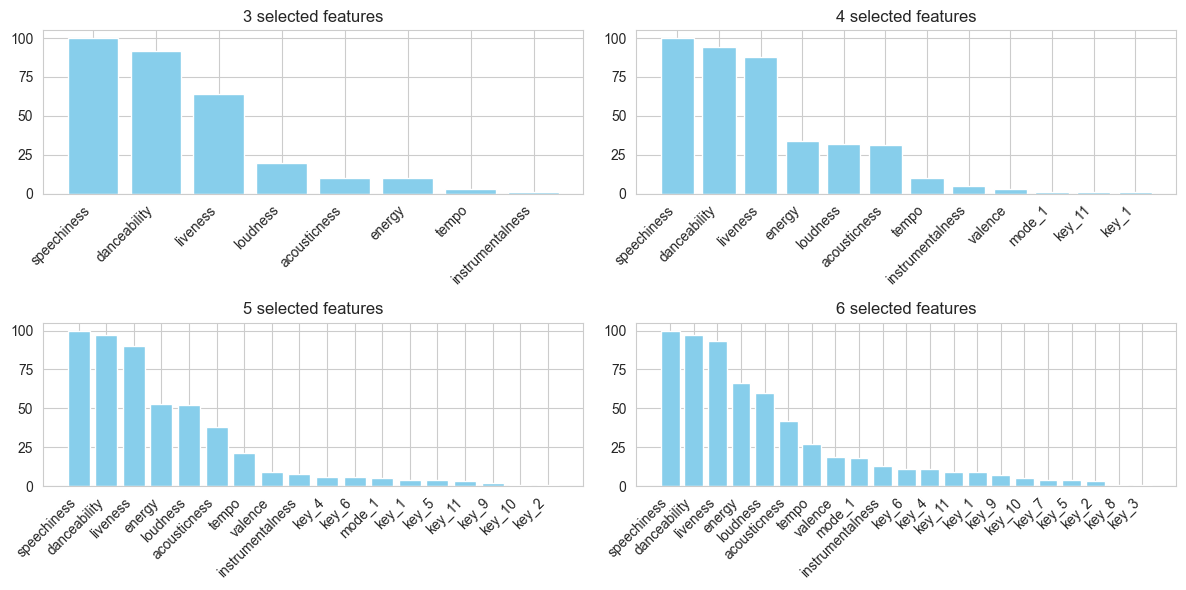

In [39]:
all_features_3 = []
all_features_4 = []
all_features_5 = []
all_features_6 = []

for seed in bestfeatures[4]:
    all_features_3.extend(bestfeatures[3][seed])
    all_features_4.extend(bestfeatures[4][seed])
    all_features_5.extend(bestfeatures[5][seed])
    all_features_6.extend(bestfeatures[6][seed])

feature_counts_3 = Counter(all_features_3)
feature_counts_4 = Counter(all_features_4)
feature_counts_5 = Counter(all_features_5)
feature_counts_6 = Counter(all_features_6)

sorted_categories_3 = sorted(feature_counts_3.items(), key=lambda x: x[1], reverse=True)
sorted_categories_4 = sorted(feature_counts_4.items(), key=lambda x: x[1], reverse=True)
sorted_categories_5 = sorted(feature_counts_5.items(), key=lambda x: x[1], reverse=True)
sorted_categories_6 = sorted(feature_counts_6.items(), key=lambda x: x[1], reverse=True)
categories_3, counts_3 = zip(*sorted_categories_3)
categories_4, counts_4 = zip(*sorted_categories_4)
categories_5, counts_5 = zip(*sorted_categories_5)
categories_6, counts_6 = zip(*sorted_categories_6)

# Create a bar plot
# Create bars for each feature
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0, 0].bar(categories_3, counts_3, color='skyblue')
axs[0, 0].set_title('3 selected features')
axs[0, 0].set_xticks(range(len(categories_3)))  # Set positions for ticks
axs[0, 0].set_xticklabels(categories_3, rotation=45, ha='right')

axs[0, 1].bar(categories_4, counts_4, color='skyblue')
axs[0, 1].set_title('4 selected features')
axs[0, 1].set_xticks(range(len(categories_4)))  # Set positions for ticks
axs[0, 1].set_xticklabels(categories_4, rotation=45, ha='right')

axs[1, 0].bar(categories_5, counts_5, color='skyblue')
axs[1, 0].set_title('5 selected features')
axs[1, 0].set_xticks(range(len(categories_5)))  # Set positions for ticks
axs[1, 0].set_xticklabels(categories_5, rotation=45, ha='right')

axs[1, 1].bar(categories_6, counts_6, color='skyblue')
axs[1, 1].set_title('6 selected features')
axs[1, 1].set_xticks(range(len(categories_6)))  # Set positions for ticks
axs[1, 1].set_xticklabels(categories_6, rotation=45, ha='right')

# plt.ylabel('Count', fontsize=16)
# for i, count in enumerate(counts):
#     plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.savefig('FeatureImportance_3456.eps', format='eps')
plt.show()

The more features we try to use, the more diverse the composition of different "best" feature sets are. This is another reason why using fewer features make more sense. I chose 4 features. To find the fourth (ambiguity between energy, loudness and acousticness), I do some comparisons

# <span style="color:red">Comparing different 4-feature models</span>

In [40]:
final_features_1 = ['speechiness', 'danceability', 'liveness', 'energy']
final_features_2 = ['speechiness', 'danceability', 'liveness', 'loudness']
final_features_3 = ['speechiness', 'danceability', 'liveness', 'acousticness']
accuracy_final_dict_1 = {}
accuracy_final_dict_2 = {}
accuracy_final_dict_3 = {}
# getting an idea of accuracy:
for i in [10, 20, 30]:
    accuracy_final_dict_1[i] = {}
    accuracy_final_dict_2[i] = {}
    accuracy_final_dict_3[i] = {}
    for seed in range(200):
        print(f'Training split: {i/100}, seed = {seed}')
        predictors_train_final_1, predictors_test_final_1, response_train_final_1, response_test_final_1 = train_test_split(encoded_data[final_features_1], response, test_size=i/100, random_state=seed)
        predictors_train_final_2, predictors_test_final_2, response_train_final_2, response_test_final_2 = train_test_split(encoded_data[final_features_2], response, test_size=i/100, random_state=seed)
        predictors_train_final_3, predictors_test_final_3, response_train_final_3, response_test_final_3 = train_test_split(encoded_data[final_features_3], response, test_size=i/100, random_state=seed)
        
        model_1, accuracy_1 = svm_model('rbf', predictors_train_final_1, response_train_final_1, predictors_test_final_1, response_test_final_1, metrics = 'None')
        model_2, accuracy_2 = svm_model('rbf', predictors_train_final_2, response_train_final_2, predictors_test_final_2, response_test_final_2, metrics = 'None')
        model_3, accuracy_3 = svm_model('rbf', predictors_train_final_3, response_train_final_3, predictors_test_final_3, response_test_final_3, metrics = 'None')
        
        accuracy_final_dict_1[i][seed] = accuracy_1
        accuracy_final_dict_2[i][seed] = accuracy_2
        accuracy_final_dict_3[i][seed] = accuracy_3


Training split: 0.1, seed = 0
Training split: 0.1, seed = 1
Training split: 0.1, seed = 2
Training split: 0.1, seed = 3
Training split: 0.1, seed = 4
Training split: 0.1, seed = 5
Training split: 0.1, seed = 6
Training split: 0.1, seed = 7
Training split: 0.1, seed = 8
Training split: 0.1, seed = 9
Training split: 0.1, seed = 10
Training split: 0.1, seed = 11
Training split: 0.1, seed = 12
Training split: 0.1, seed = 13
Training split: 0.1, seed = 14
Training split: 0.1, seed = 15
Training split: 0.1, seed = 16
Training split: 0.1, seed = 17
Training split: 0.1, seed = 18
Training split: 0.1, seed = 19
Training split: 0.1, seed = 20
Training split: 0.1, seed = 21
Training split: 0.1, seed = 22
Training split: 0.1, seed = 23
Training split: 0.1, seed = 24
Training split: 0.1, seed = 25
Training split: 0.1, seed = 26
Training split: 0.1, seed = 27
Training split: 0.1, seed = 28
Training split: 0.1, seed = 29
Training split: 0.1, seed = 30
Training split: 0.1, seed = 31
Training split: 0.

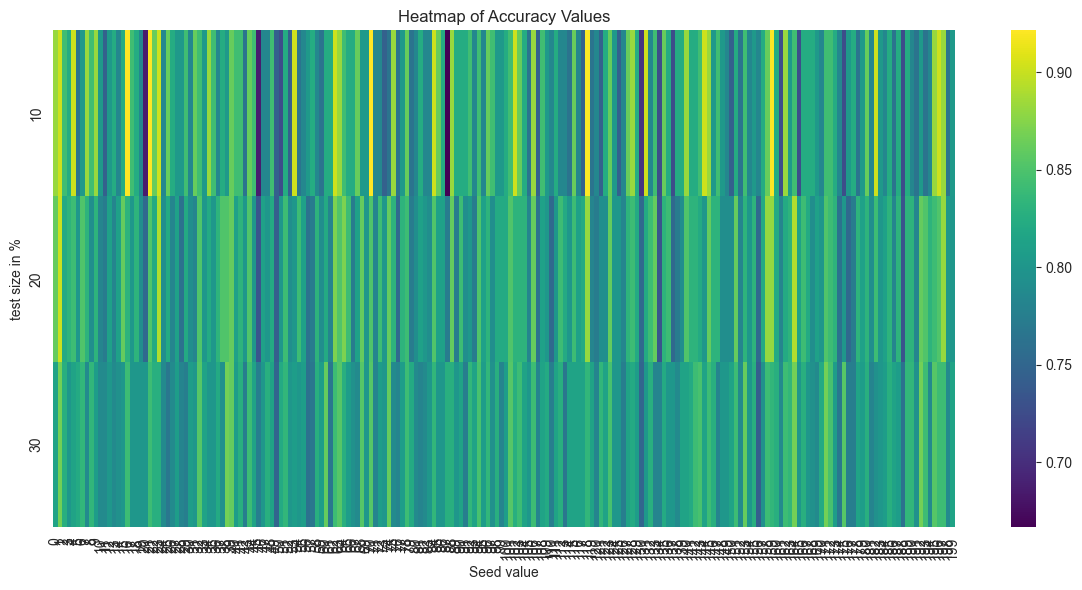

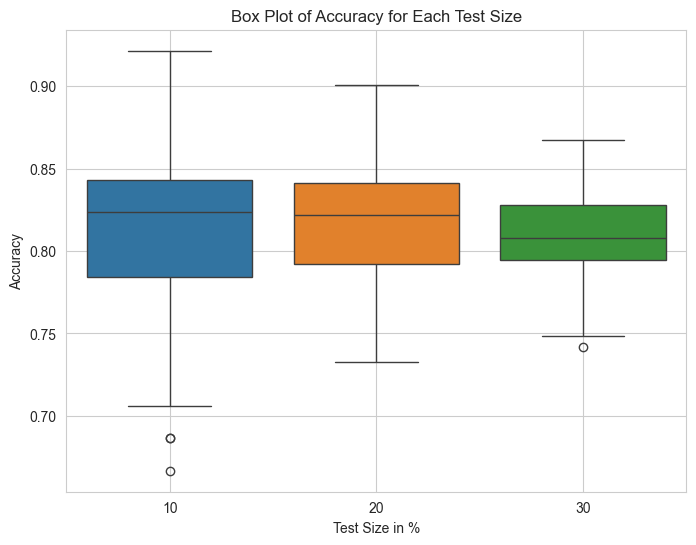

Max: 
 10    0.921569
20    0.900990
30    0.867550
dtype: float64
Min: 
 10    0.666667
20    0.732673
30    0.741722
dtype: float64
Mean: 
 10    0.816667
20    0.815891
30    0.811954
dtype: float64
Seed for max. accuracy at 10%: 16
Seed for max. accuracy at 20%: 1
Seed for max. accuracy at 30%: 1


In [42]:
splits = sorted(accuracy_final_dict_1.keys())
seed_nrs = range(200)
Z = np.array([[accuracy_final_dict_1[split][seed_nr] for split in splits] for seed_nr in seed_nrs])

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(Z.T, xticklabels=seed_nrs, yticklabels=splits, cmap='viridis', annot=False)
plt.xlabel('Seed value')
plt.ylabel('test size in %')
plt.title('Heatmap of Accuracy Values')
plt.tight_layout()
plt.savefig('Accuracy_heatmap_4_energy.eps', format='eps')
plt.show()

df1 = pd.DataFrame(accuracy_final_dict_1)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df1)
plt.title('Box Plot of Accuracy for Each Test Size')
plt.xlabel('Test Size in %')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('Boxplot_4_energy.eps', format='eps')
plt.show()

print(f'Max: \n {df1.max()}')
print(f'Min: \n {df1.min()}')
print(f'Mean: \n {df1.mean()}')
print(f'Seed for max. accuracy at 10%: {max(accuracy_final_dict_1[10], key=accuracy_final_dict_1[10].get)}')
print(f'Seed for max. accuracy at 20%: {max(accuracy_final_dict_1[20], key=accuracy_final_dict_1[20].get)}')
print(f'Seed for max. accuracy at 30%: {max(accuracy_final_dict_1[30], key=accuracy_final_dict_1[30].get)}')


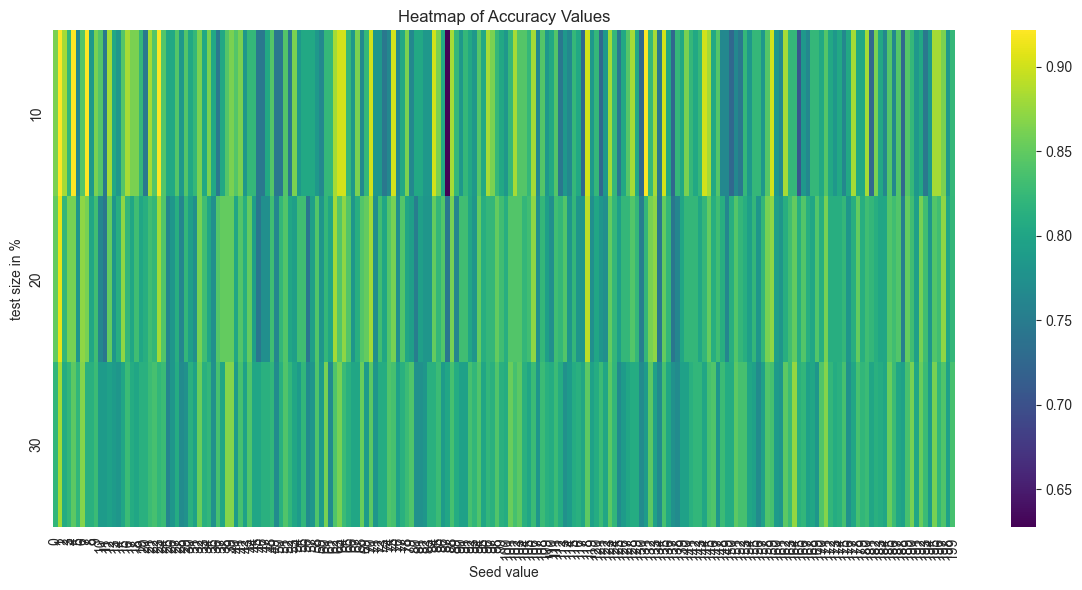

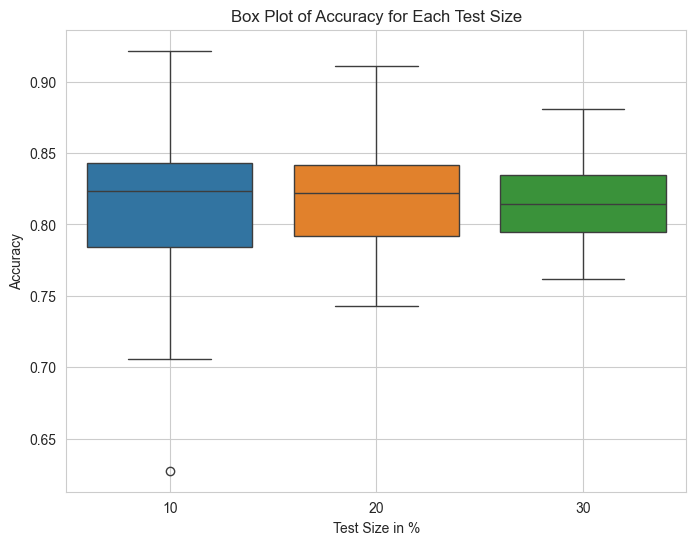

Max: 
 10    0.921569
20    0.910891
30    0.880795
dtype: float64
Min: 
 10    0.627451
20    0.742574
30    0.761589
dtype: float64
Mean: 
 10    0.816569
20    0.817228
30    0.813775
dtype: float64
Seed for max. accuracy at 10%: 1
Seed for max. accuracy at 20%: 1
Seed for max. accuracy at 30%: 1
Seed for min. accuracy at 10%: 87
Seed for min. accuracy at 20%: 11
Seed for min. accuracy at 30%: 25


In [110]:
splits = sorted(accuracy_final_dict_2.keys())
seed_nrs = range(200)
Z = np.array([[accuracy_final_dict_2[split][seed_nr] for split in splits] for seed_nr in seed_nrs])

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(Z.T, xticklabels=seed_nrs, yticklabels=splits, cmap='viridis', annot=False)
plt.xlabel('Seed value')
plt.ylabel('test size in %')
plt.title('Heatmap of Accuracy Values')
plt.tight_layout()
plt.savefig('Accuracy_heatmap_4_loudness.eps', format='eps')
plt.show()

df2 = pd.DataFrame(accuracy_final_dict_2)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df2)
plt.title('Box Plot of Accuracy for Each Test Size')
plt.xlabel('Test Size in %')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('Boxplot_4_loudness.eps', format='eps')
plt.show()

print(f'Max: \n {df2.max()}')
print(f'Min: \n {df2.min()}')
print(f'Mean: \n {df2.mean()}')
print(f'Seed for max. accuracy at 10%: {max(accuracy_final_dict_2[10], key=accuracy_final_dict_2[10].get)}')
print(f'Seed for max. accuracy at 20%: {max(accuracy_final_dict_2[20], key=accuracy_final_dict_2[20].get)}')
print(f'Seed for max. accuracy at 30%: {max(accuracy_final_dict_2[30], key=accuracy_final_dict_2[30].get)}')

print(f'Seed for min. accuracy at 10%: {min(accuracy_final_dict_2[10], key=accuracy_final_dict_2[10].get)}')
print(f'Seed for min. accuracy at 20%: {min(accuracy_final_dict_2[20], key=accuracy_final_dict_2[20].get)}')
print(f'Seed for min. accuracy at 30%: {min(accuracy_final_dict_2[30], key=accuracy_final_dict_2[30].get)}')

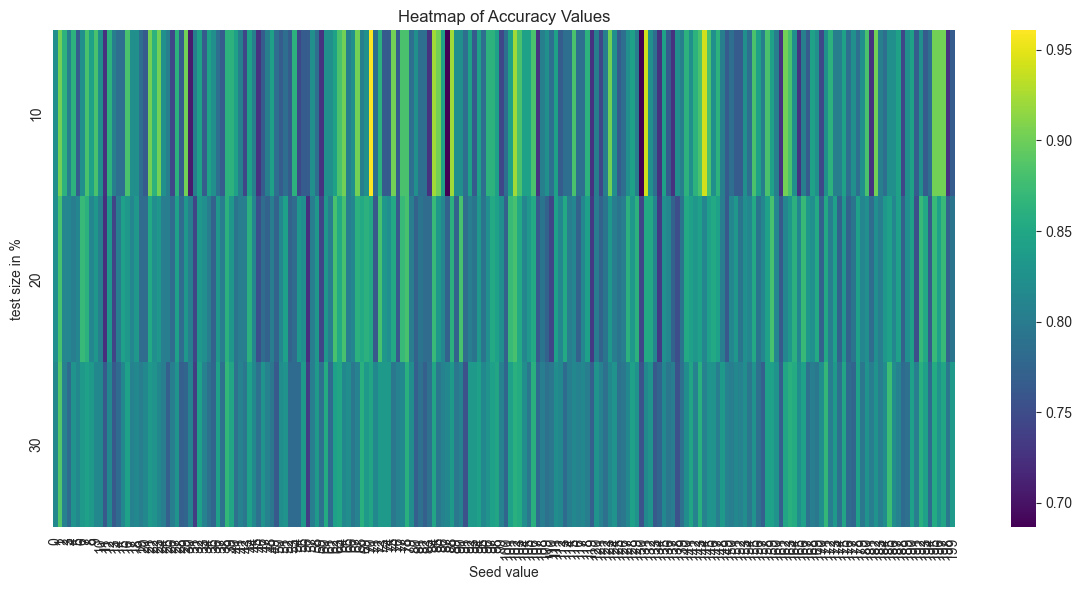

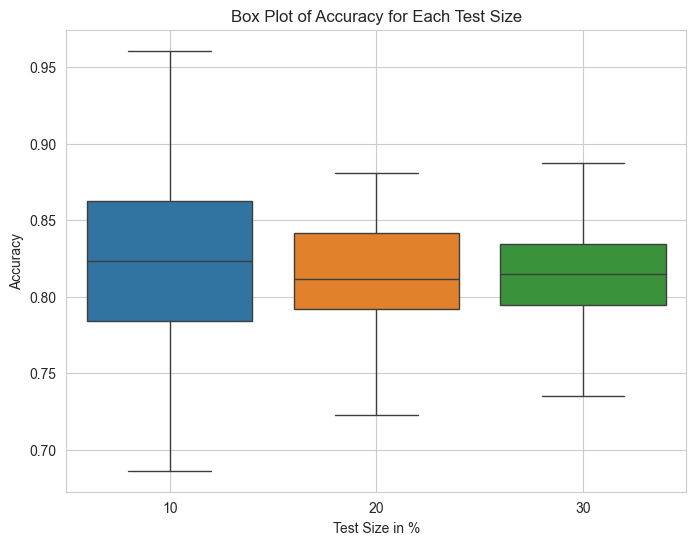

Max: 
 10    0.960784
20    0.881188
30    0.887417
dtype: float64
Min: 
 10    0.686275
20    0.722772
30    0.735099
dtype: float64
Mean: 
 10    0.817157
20    0.815198
30    0.812616
dtype: float64
Seed for max. accuracy at 10%: 70
Seed for max. accuracy at 20%: 1
Seed for max. accuracy at 30%: 1


In [44]:
splits = sorted(accuracy_final_dict_3.keys())
seed_nrs = range(200)
Z = np.array([[accuracy_final_dict_3[split][seed_nr] for split in splits] for seed_nr in seed_nrs])

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(Z.T, xticklabels=seed_nrs, yticklabels=splits, cmap='viridis', annot=False)
plt.xlabel('Seed value')
plt.ylabel('test size in %')
plt.title('Heatmap of Accuracy Values')
plt.tight_layout()
plt.savefig('Accuracy_heatmap_4_loudness.eps', format='eps')
plt.show()

df3 = pd.DataFrame(accuracy_final_dict_3)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df3)
plt.title('Box Plot of Accuracy for Each Test Size')
plt.xlabel('Test Size in %')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('Boxplot_4_loudness.eps', format='eps')
plt.show()

print(f'Max: \n {df3.max()}')
print(f'Min: \n {df3.min()}')
print(f'Mean: \n {df3.mean()}')
print(f'Seed for max. accuracy at 10%: {max(accuracy_final_dict_3[10], key=accuracy_final_dict_3[10].get)}')
print(f'Seed for max. accuracy at 20%: {max(accuracy_final_dict_3[20], key=accuracy_final_dict_3[20].get)}')
print(f'Seed for max. accuracy at 30%: {max(accuracy_final_dict_3[30], key=accuracy_final_dict_3[30].get)}')

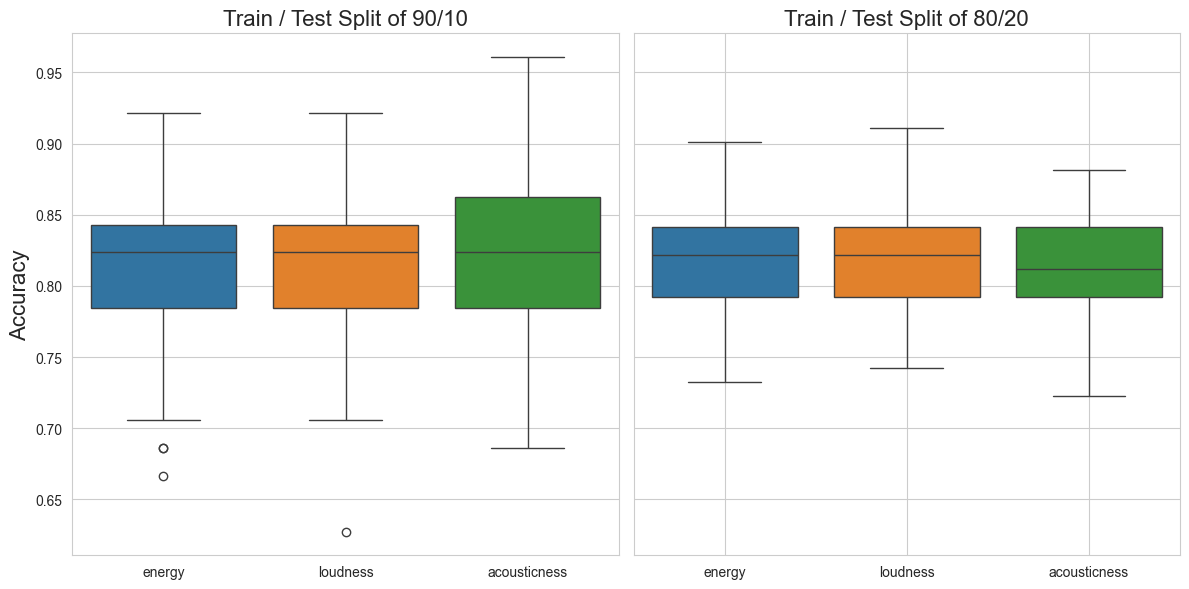

In [80]:
df_20 = pd.concat([df1[20], df2[20], df3[20]], axis=1)
df_20.columns = ['energy', 'loudness', 'acousticness']
df_10 = pd.concat([df1[10], df2[10], df3[10]], axis=1)
df_10.columns = ['energy', 'loudness', 'acousticness']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

sns.boxplot(data=df_10, ax=axs[0])
sns.boxplot(data=df_20, ax=axs[1])
axs[0].set_title('Train / Test Split of 90/10', fontsize=16)
axs[1].set_title('Train / Test Split of 80/20', fontsize=16)
axs[0].set_ylabel('Accuracy', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('Boxplot_4_combo.eps', format='eps')
plt.show()

Smaller test size with such small database is more prone to "lucky" and "unlucky" splits, thus both the max. and min. accuracy values are in the 10% bracket, and by seeing that the average accuracy drops by increasing the testing set size, we can infer that accuracy is very much dependent on the training set size.

Final choice for features: speechiness, danceability, liveness, loudness

# Final SVM Model

In [159]:
train_file_path = '../project_train.csv'
test_file_path = '../project_test.csv'

data_train = pd.read_csv(train_file_path)
data_test = pd.read_csv(test_file_path)

features_needed = ['danceability','speechiness', 'liveness', 'loudness']  # Based on the feature selection process described in the report

training_set = data_train[features_needed + ['Label']]

rows_to_remove = [68, 84, 94]  # 68: speechiness outlier, 84: energy false data, 94: loudness false data
print(f'Rows removed: \n {training_set.iloc[rows_to_remove]}')
training_set = training_set.drop(rows_to_remove)
training_set = training_set.reset_index(drop=True)

testing_set = data_test[features_needed]

# Transformation and scaling
vars_to_transform = [
    "speechiness",
    "danceability",
    "liveness"
]

training_set_transformed = training_set.copy()
training_set_transformed[vars_to_transform] = training_set_transformed[vars_to_transform].transform(logit)
training_set_transformed[vars_to_transform + ['loudness']] = preprocessing.scale(training_set_transformed[vars_to_transform + ['loudness']])

testing_set_transformed = testing_set.copy()
testing_set_transformed[vars_to_transform] = testing_set_transformed[vars_to_transform].transform(logit)
testing_set_transformed[vars_to_transform + ['loudness']] = preprocessing.scale(testing_set_transformed[vars_to_transform + ['loudness']])

Rows removed: 
     danceability  speechiness  liveness  loudness  Label
68         0.715       0.9250     0.688   -13.843      0
84         0.705       0.0775     0.048    -4.551      1
94         0.578       0.0363     0.285 -6542.000      1


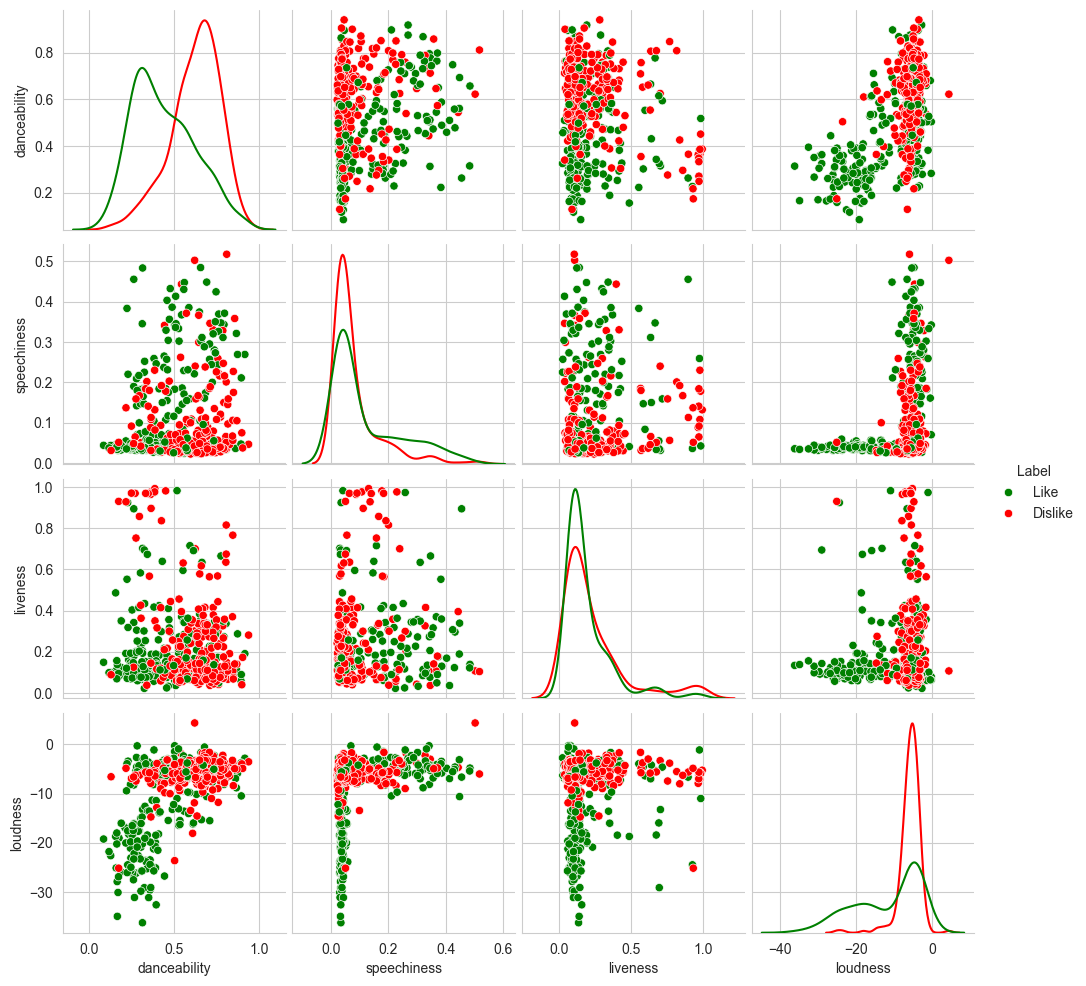

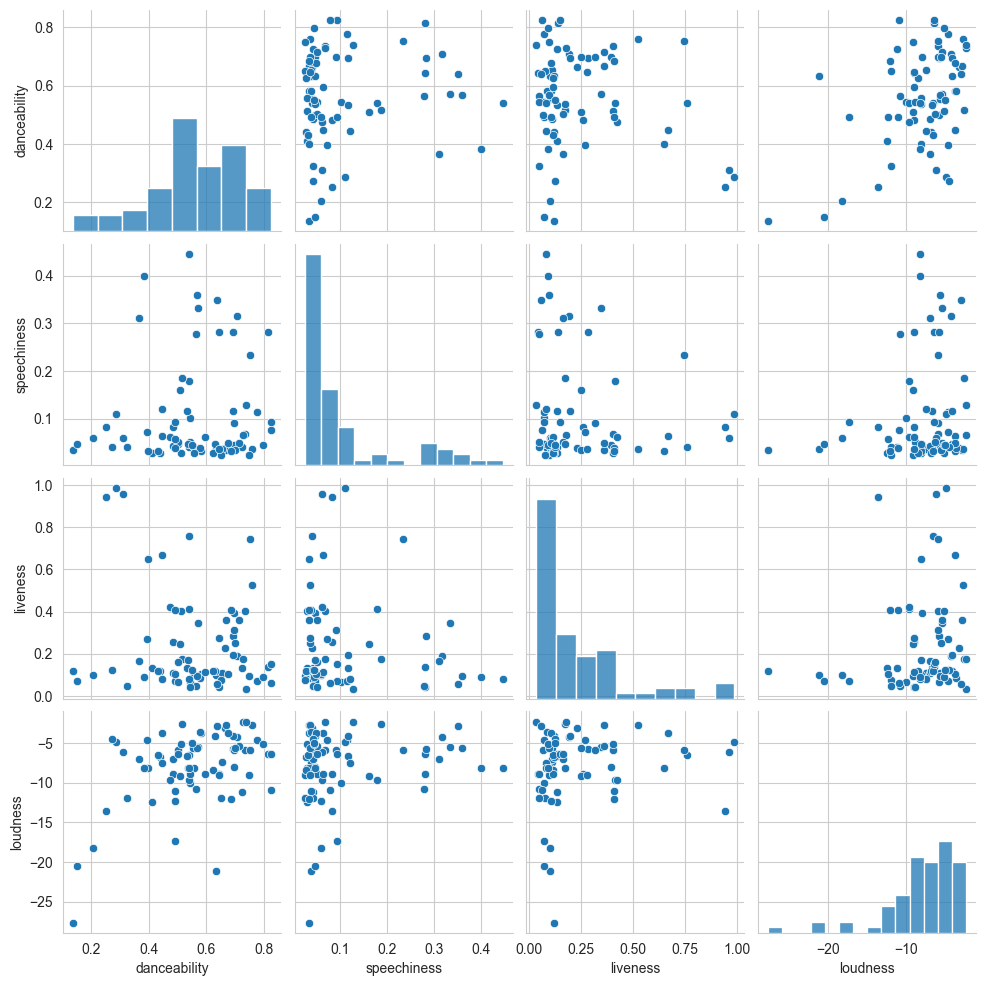

In [95]:
# Pair plot of original labelled data
display_train = training_set.copy()
display_train['Label'] = display_train['Label'].map({0: 'Dislike', 1: 'Like'})
 

sns.pairplot(display_train, hue="Label", diag_kws={'fill': False}, palette={'Dislike': 'red', 'Like': 'green'})
plt.show()

# Pair plot of original unlabelled data
sns.pairplot(testing_set, hue=None)
plt.show()

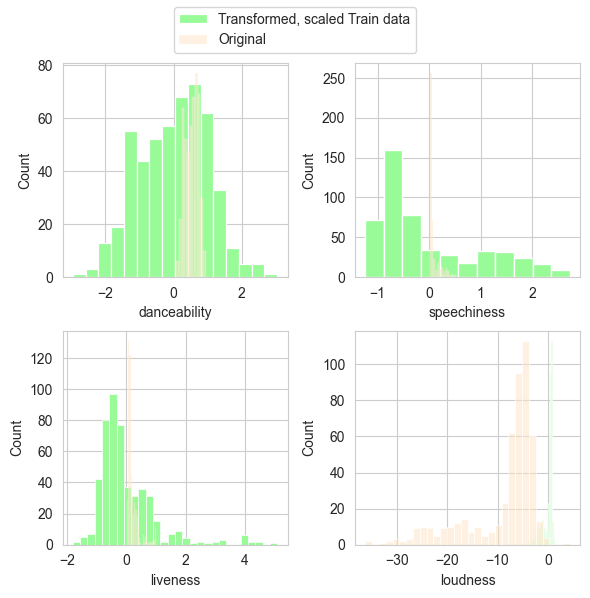

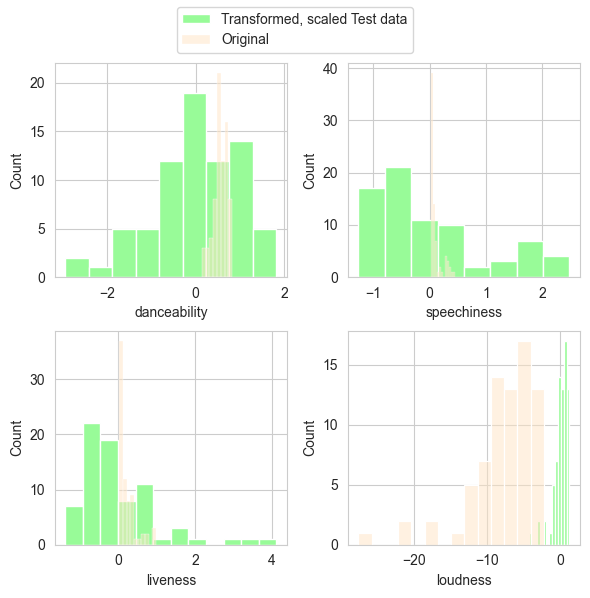

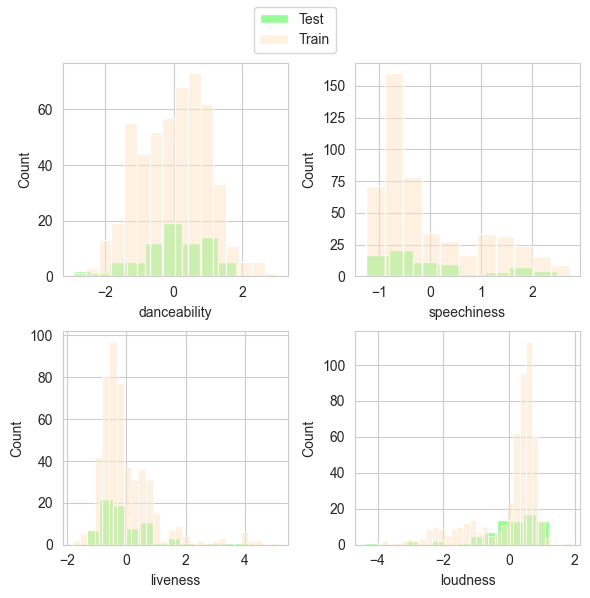

In [96]:
# Distribution of transformed and scaled data compared to original
fig1, axes1 = plt.subplots(2, 2, figsize=(6, 6))
axes1 = axes1.flatten()

for i, col in enumerate(training_set[features_needed].columns):
    sns.histplot(training_set_transformed[col], ax=axes1[i], alpha=1, color='palegreen', label='Transformed, scaled Train data')
    sns.histplot(training_set[col], ax=axes1[i], alpha=0.5, color='bisque', label='Original')
    axes1[i].set_xlabel(col)
    axes1[i].set_ylabel('Count')
fig1.subplots_adjust(top=0.8)
handles, labels = axes1[0].get_legend_handles_labels()
fig1.legend(handles, ['Transformed, scaled Train data', 'Original'], loc='upper center')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


fig2, axes2 = plt.subplots(2, 2, figsize=(6, 6))
axes2 = axes2.flatten()

for i, col in enumerate(testing_set.columns):
    sns.histplot(testing_set_transformed[col], ax=axes2[i],alpha=1, color='palegreen', label='Transformed, scaled Test data')
    sns.histplot(testing_set[col], ax=axes2[i], alpha=0.5, color='bisque', label='Original')
    axes2[i].set_xlabel(col)
    axes2[i].set_ylabel('Count')
fig2.subplots_adjust(top=0.8)
handles, labels = axes2[0].get_legend_handles_labels()
fig2.legend(handles, ['Transformed, scaled Test data', 'Original'], loc='upper center')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


fig3, axes3 = plt.subplots(2, 2, figsize=(6, 6))
axes3 = axes3.flatten()

for i, col in enumerate(testing_set.columns):
    sns.histplot(testing_set_transformed[col], ax=axes3[i],alpha=1, color='palegreen', label='Test')
    sns.histplot(training_set_transformed[col], ax=axes3[i], alpha=0.5, color='bisque', label='Train')
    axes3[i].set_xlabel(col)
    axes3[i].set_ylabel('Count')
fig3.subplots_adjust(top=0.8)
handles, labels = axes2[0].get_legend_handles_labels()
fig3.legend(handles, ['Test', 'Train'], loc='upper center')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [160]:
predictors_train = training_set_transformed[features_needed]
response_train = training_set_transformed['Label']

model = SVC(kernel='rbf', random_state=0)
model.fit(predictors_train, response_train)

response_pred = model.predict(testing_set_transformed)

data_test['Label_Pred'] = response_pred

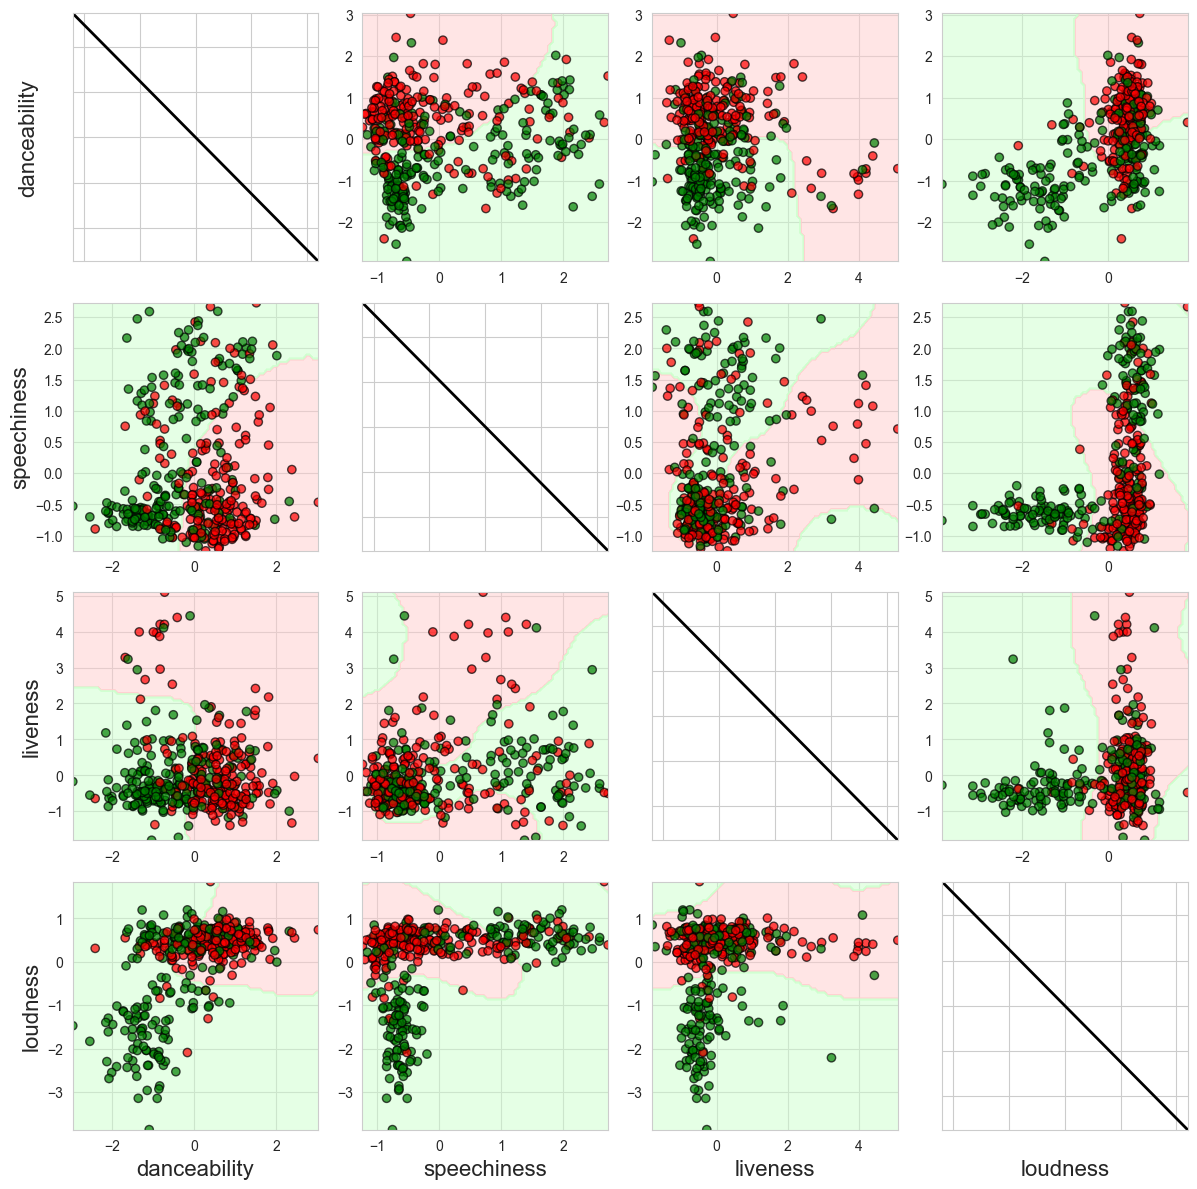

In [49]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharex=False, sharey=False)

# Define custom colors for the classes
cmap_light = ListedColormap(['#ffcccc', '#ccffcc'])  # Light red and light green for decision boundaries
cmap_bold = ['red', 'green']  # Red and green for the points
formatter = FuncFormatter(lambda x, _: f'{abs(x):.1f}')

for i in range(len(predictors_train.columns)):
    for j in range(len(predictors_train.columns)):
        feature1 = j
        feature2 = i
        ax = axes[i, j]

        if i != j:
            X = predictors_train.to_numpy()[:, [feature1, feature2]]
            classifier = SVC(kernel='rbf', random_state=0).fit(X, response_train)

            disp = DecisionBoundaryDisplay.from_estimator(
                classifier, X, response_method="predict",
                xlabel=predictors_train.columns[feature1],
                ylabel=predictors_train.columns[feature2],
                alpha=0.5, ax=ax, cmap=cmap_light
            )

            ax.scatter(X[:, 0], X[:, 1], c=response_train, cmap=ListedColormap(cmap_bold), edgecolor="k", alpha=0.7)

            x_min, x_max = X[:, 0].min(), X[:, 0].max()
            y_min, y_max = X[:, 1].min(), X[:, 1].max()
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_xlabel(predictors_train.columns[feature1], fontsize=16)
            ax.set_ylabel(predictors_train.columns[feature2], fontsize=16)
        else:
            ax.plot([0, 1], [1, 0], transform=ax.transAxes, color='black', linewidth=2)
            ax.set_xlabel(predictors_train.columns[feature1], fontsize=16)
            ax.set_ylabel(predictors_train.columns[feature2], fontsize=16)
            # ax.set_xticks([])
            # ax.set_yticks([])
            ax.tick_params(axis='x', colors='white')
            ax.tick_params(axis='y', colors='white')
            ax.xaxis.set_major_formatter(formatter)
            ax.yaxis.set_major_formatter(formatter)

        if j > 0:
            ax.set_ylabel('')

        if i < len(predictors_train.columns) - 1:
            ax.set_xlabel('')

plt.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


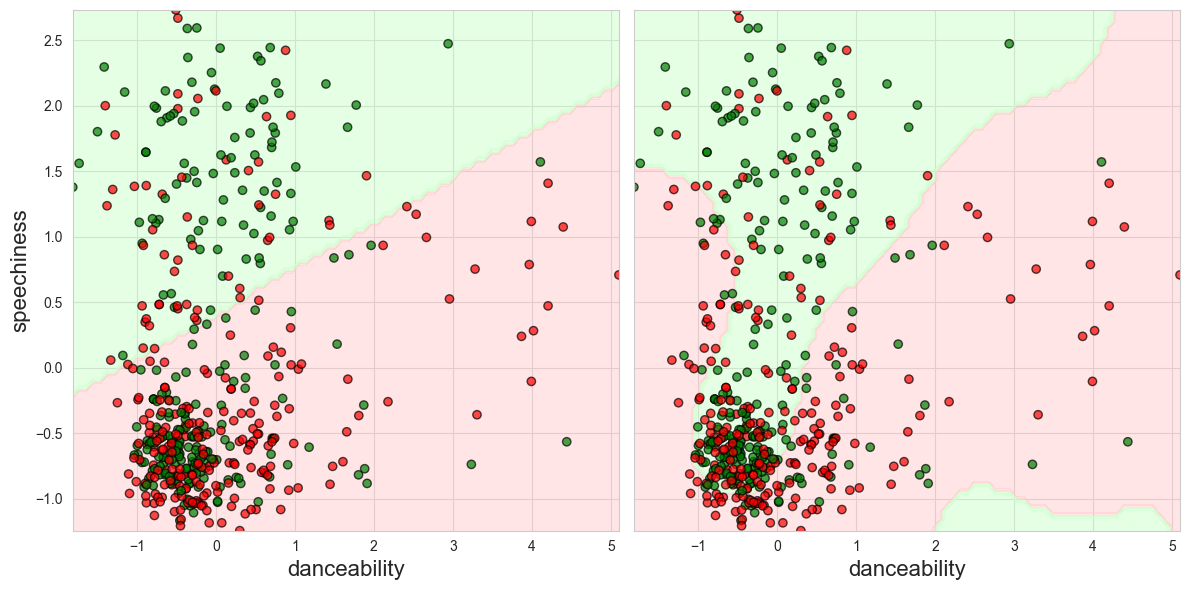

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=False, sharey=True)

X = predictors_train.to_numpy()[:, [2, 1]]
classifier = SVC(kernel='linear', random_state=0).fit(X, response_train)
disp1 = DecisionBoundaryDisplay.from_estimator(
                classifier, X, response_method="predict",
                xlabel=predictors_train.columns[0],
                ylabel=predictors_train.columns[1],
                alpha=0.5, ax=axes[0], cmap=cmap_light
            )

axes[0].scatter(X[:, 0], X[:, 1], c=response_train, cmap=ListedColormap(cmap_bold), edgecolor="k", alpha=0.7)

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[0].set_xlabel(predictors_train.columns[0], fontsize=16)
axes[0].set_ylabel(predictors_train.columns[1], fontsize=16)

classifier = SVC(kernel='rbf', random_state=0).fit(X, response_train)
disp2 = DecisionBoundaryDisplay.from_estimator(
                classifier, X, response_method="predict",
                xlabel=predictors_train.columns[0],
                ylabel=predictors_train.columns[1],
                alpha=0.5, ax=axes[1], cmap=cmap_light
            )

axes[1].scatter(X[:, 0], X[:, 1], c=response_train, cmap=ListedColormap(cmap_bold), edgecolor="k", alpha=0.7)

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)
axes[1].set_xlabel(predictors_train.columns[0], fontsize=16)
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('SVM_DecisionBoundaries_linVSrbf.eps', format='eps')
plt.show()

In [151]:
# Write results into CSV file

data_test.to_csv('project_test_predictions_SVM.csv', index=False)

In [161]:
# Testing final model accuracy

predictors_train, predictors_test, response_train, response_test = train_test_split(training_set_transformed[['danceability','speechiness', 'liveness', 'loudness']], training_set_transformed['Label'], test_size=0.2, random_state=0)

model, _ = svm_model('rbf', predictors_train, response_train, predictors_test, response_test)

accuracy_svm = accuracy_score(response_test, model.predict(predictors_test))
precision_svm = precision_score(response_test, model.predict(predictors_test))
recall_svm = recall_score(response_test, model.predict(predictors_test))
kappa_svm = cohen_kappa_score(response_test, model.predict(predictors_test))


Accuracy: 85.15%
Precision: 90.24%
Recall: 77.08%
Cohen's Kappa Score: 0.70


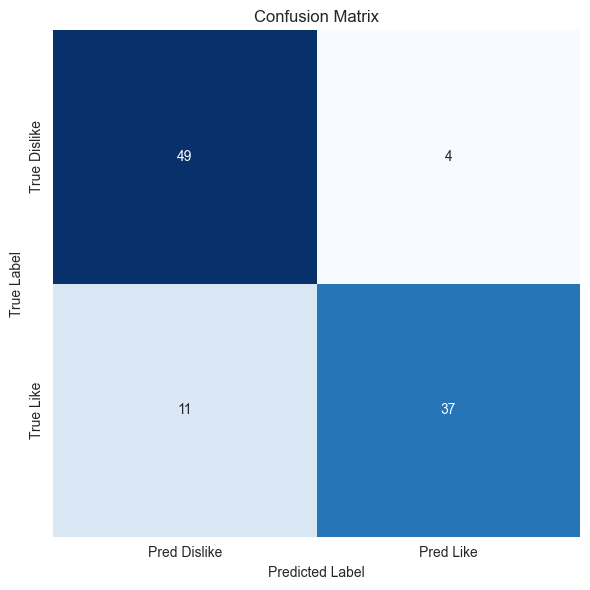

In [162]:
# Compute confusion matrix
cm_SVM = confusion_matrix(response_test, model.predict(predictors_test))

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm_SVM, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Dislike', 'Pred Like'], yticklabels=['True Dislike', 'True Like'], cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()